In [5]:
import torch
import torch.nn as nn 
from torchvision.datasets import MNIST

from torchvision import transforms as transforms
from torch_snippets import *

device = "cuda" if torch.cuda.is_available() else "cpu"


BATCH_SIZE = 16
LR = 1e-3

In [6]:
img_transformation = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5],[0.5]),
    transforms.Lambda(lambda x: x.to(device))    
])

train_ds = MNIST("AutoEncoders/data",train=True,download=True,transform=img_transformation)
val_ds = MNIST("AutoEncoders/data",train=False,download=False,transform=img_transformation)

train_dl = torch.utils.data.DataLoader(train_ds,batch_size=BATCH_SIZE,shuffle=True)
val_dl = torch.utils.data.DataLoader(val_ds,batch_size=BATCH_SIZE,shuffle=True)


In [12]:
class Conv_AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.encoder = nn.Sequential(
            nn.Conv2d(1,32,3,stride=3,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2,stride=2),
            nn.Conv2d(32,64,3,stride=2,padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2,stride=1)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64,32,3,stride=2),
            nn.ReLU(True),
            nn.ConvTranspose2d(32,16,5,stride=3,padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(16,1,2,stride=2,padding=1),
            nn.Tanh(),
        )
        
    def forward(self,x:torch.Tensor)-> torch.Tensor:
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [13]:
def train_batch(input,model,loss_fn,optimizer):
    model.train()
    optimizer.zero_grad()
    output = model(input)
    loss = loss_fn(output,input)
    loss.backward()
    optimizer.step()
    
    return loss

def validate_batch(input,model,loss_fn):
    model.train()
    output = model(input)
    loss = loss_fn(output,input)
    
    return loss

In [14]:
model = Conv_AutoEncoder().to(device)

In [15]:
import torchsummary

torchsummary.summary(model,torch.zeros(2,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 2, 2]            --
|    └─Conv2d: 2-1                       [-1, 32, 10, 10]          320
|    └─ReLU: 2-2                         [-1, 32, 10, 10]          --
|    └─MaxPool2d: 2-3                    [-1, 32, 5, 5]            --
|    └─Conv2d: 2-4                       [-1, 64, 3, 3]            18,496
|    └─ReLU: 2-5                         [-1, 64, 3, 3]            --
|    └─MaxPool2d: 2-6                    [-1, 64, 2, 2]            --
├─Sequential: 1-2                        [-1, 1, 28, 28]           --
|    └─ConvTranspose2d: 2-7              [-1, 32, 5, 5]            18,464
|    └─ReLU: 2-8                         [-1, 32, 5, 5]            --
|    └─ConvTranspose2d: 2-9              [-1, 16, 15, 15]          12,816
|    └─ReLU: 2-10                        [-1, 16, 15, 15]          --
|    └─ConvTranspose2d: 2-11             [-1, 1, 28, 28]           65
| 

In [16]:
optimizer = torch.optim.Adam(model.parameters(),lr=1e-3,weight_decay=1e-5)
loss_fn = nn.MSELoss()

EPOCH: 0.000  trn_loss: 0.170  (0.04s - 699.11s remaining)
EPOCH: 0.001  trn_loss: 0.162  (0.07s - 702.17s remaining)
EPOCH: 0.001  trn_loss: 0.163  (0.11s - 711.33s remaining)
EPOCH: 0.001  trn_loss: 0.149  (0.15s - 710.11s remaining)
EPOCH: 0.001  trn_loss: 0.156  (0.18s - 692.94s remaining)
EPOCH: 0.002  trn_loss: 0.136  (0.22s - 672.56s remaining)
EPOCH: 0.002  trn_loss: 0.127  (0.24s - 639.01s remaining)
EPOCH: 0.002  trn_loss: 0.142  (0.28s - 657.39s remaining)
EPOCH: 0.002  trn_loss: 0.150  (0.31s - 653.03s remaining)
EPOCH: 0.003  trn_loss: 0.124  (0.34s - 633.06s remaining)
EPOCH: 0.003  trn_loss: 0.127  (0.36s - 605.43s remaining)
EPOCH: 0.003  trn_loss: 0.119  (0.37s - 579.93s remaining)
EPOCH: 0.003  trn_loss: 0.137  (0.39s - 555.49s remaining)
EPOCH: 0.004  trn_loss: 0.167  (0.42s - 557.26s remaining)
EPOCH: 0.004  trn_loss: 0.124  (0.44s - 550.56s remaining)
EPOCH: 0.004  trn_loss: 0.155  (0.46s - 537.59s remaining)
EPOCH: 0.005  trn_loss: 0.142  (0.48s - 533.71s remainin

100%|██████████| 106/106 [00:00<00:00, 299.27it/s]


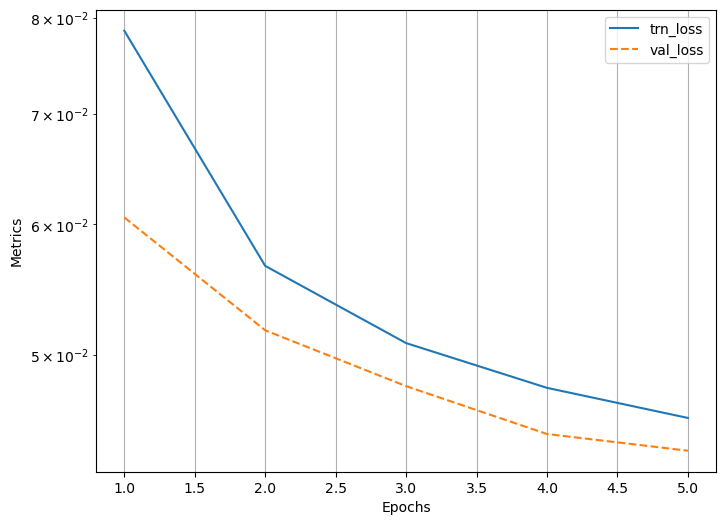

In [18]:
num_epochs = 5
log = Report(num_epochs)

for epoch in range(num_epochs):
    N = len(train_dl)
    for ix, (x,_) in enumerate(train_dl):
        loss = train_batch(x,model,loss_fn,optimizer)
        log.record(pos = epoch +(ix+1)/N, trn_loss = loss)
        
    N = len(val_dl)
    with torch.inference_mode():
        for ix , (x,_) in enumerate(val_dl):
            loss = validate_batch(x,model,loss_fn)
            log.record(pos = epoch + (ix+1)/N,val_loss = loss)
    
    log.report_avgs(epoch+1)
    
log.plot_epochs(log=True)    

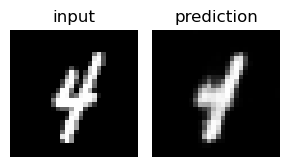

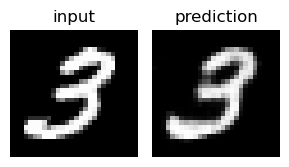

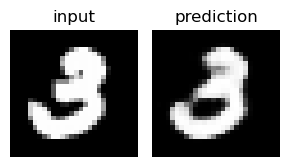

In [19]:
import numpy as np
import matplotlib.pyplot as plt

for _ in range(3):
    ix = np.random.randint(len(val_ds))
    im , _ = val_ds[ix]
    img = model(im[None])[0]
    fig, ax = plt.subplots(1,2,figsize=(3,3))
    show(im[0],ax=ax[0],title="input")
    show(img[0],ax=ax[1],title="prediction")
    plt.tight_layout()
    plt.show()

In [21]:
latent_vectors = []
classes = []

for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)


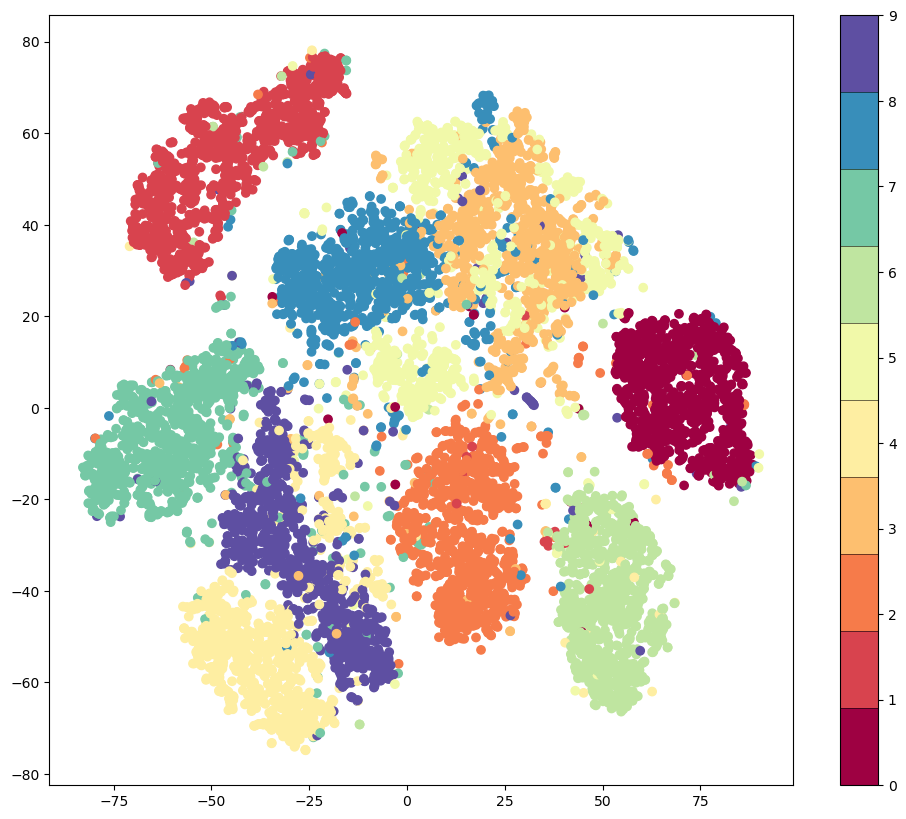

In [22]:
latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy()

from sklearn.manifold import TSNE
tsne = TSNE(2)

clustered = tsne.fit_transform(latent_vectors)

fig = plt.figure(figsize = (12,10))
cmap = plt.get_cmap('Spectral',10)
plt.scatter(*zip(*clustered),c=classes,cmap=cmap)
plt.colorbar(drawedges = True)

In [ ]:
latent_vectors = []
classes = []

for im,clss in val_dl:
    latent_vectors.append(model.encoder(im).view(len(im),-1))
    classes.extend(clss)

latent_vectors = torch.cat(latent_vectors).cpu().detach().numpy().reshape(10000,-1)


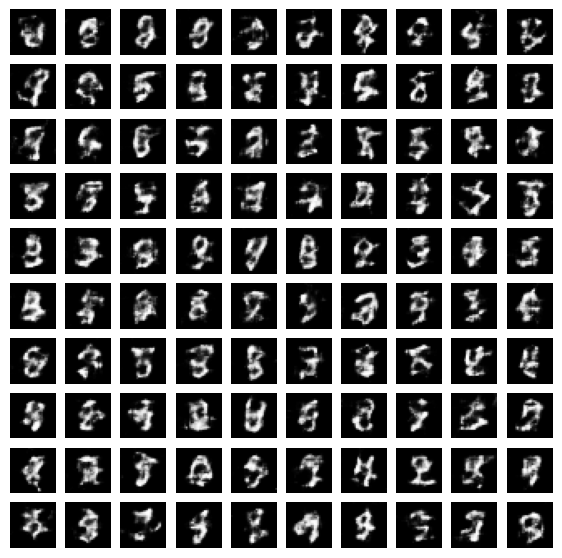

In [27]:
rand_vectors = []

for col in latent_vectors.transpose(1,0):
    mu,sigma = col.mean(),col.std()
    rand_vectors.append(sigma*torch.randn(1,100)+mu)
    
rand_vectors = torch.cat(rand_vectors).transpose(1,0).to(device)

fig,ax = plt.subplots(10,10,figsize = (7,7)) ; ax = iter(ax.flat)
for p in rand_vectors:
    img = model.decoder(p.reshape(1,64,2,2)).view(28,28)
    show(img,ax=next(ax))